# Visualize Layout Generation Process

In [1]:
%cd ..

/app


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import matplotlib.pyplot as plt
import os
import pickle
from omegaconf import DictConfig, OmegaConf
from pathlib import Path

import torch
import torch.nn as nn
from einops import rearrange, repeat
from hydra.utils import instantiate
from trainer.global_configs import DATASET_DIR
from trainer.helpers.layout_tokenizer import LayoutSequenceTokenizer
from trainer.helpers.sampling import SAMPLING_CONFIG_DICT, sample
from trainer.helpers.util import convert_xywh_to_ltrb, load_config, set_seed
from trainer.helpers.visualization import save_image
from trainer.hydra_configs import TestConfig
from trainer.models.common.util import build_model, load_model
from trainer.models.categorical_diffusion.util import index_to_log_onehot
from trainer.helpers.metric import compute_alignment, compute_overlap

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_intermediate_layout(
    layout_model: nn.Module, 
    num_samples: int, 
    sampling_cfg: DictConfig,
    keep_timesteps: list[int] = [],
    corrector: nn.Module | None = None,
    suppress_mask: bool = True,
    device: str | torch.device = torch.device("cuda:0")
) -> tuple[dict[int, torch.Tensor], dict[int, torch.Tensor]]:
    """Get layouts at intermediate timesteps for unconditional generation.

    Args:
        layout_model: a layout generator.
        num_samples: a number of generated samples.
        sampling_cfg: a sampling config to be applied.
        keep_timesteps: the timesteps when the layouts are saved.
        corrector: a layout corrector model. When None, the results of the layout_model are saved.
        suppress_mask: If true, the saved layouts does not include the MASK class.
            Note that if the one of attributes in an element is MASK, 
            the corresponding element can not be displayed.

    Returns:
        timestep2layouts: a tensor of layouts on each timestep.
        timestep2correctness: a tensor of correctness scores on each timestep.
    
    Note:
        - We suppress the logits of MASK class to obtain a layout without MASK.
        - This function may not work except LayoutDM and its conjunction with the corrector.

    """
    assert len(keep_timesteps) > 0
    assert layout_model.model.use_padding_as_vocab
    num_timesteps = sampling_cfg.num_timesteps
    num_classes = model.model.num_classes
    max_token_length = layout_model.model.max_token_length
    pad_id = layout_model.tokenizer.name_to_id("pad")
    mask_id = layout_model.tokenizer.name_to_id("mask")

    if corrector is not None:
        assert suppress_mask, "suppress_mask should be True to check how the corrector works."
        
    def get_out_index(log_one_hot, t):
        """ Helper method that partially runs `_sample_single_step()`."""
        assert isinstance(t, int)
        
        model_t = torch.full((log_one_hot.size(0), ), t, device=device, dtype=torch.long)        
        with torch.no_grad():
            log_x_recon = layout_model.model.predict_start(log_one_hot, model_t, padding_mask=None)
            model_log_prob = layout_model.model.q_posterior(
                log_x_start=log_x_recon, log_x_t=log_one_hot, t=model_t.clone()
            )
        assert model_log_prob.dim() == 3

        x0_recon_index = sample(model_log_prob, sampling_cfg)
        x0_recon_index = rearrange(x0_recon_index, "b 1 s -> b s")
        no_mask_x0_recon_index = None
        if suppress_mask:
            model_log_prob[:, mask_id, :] = -70.
            no_mask_x0_recon_index = sample(model_log_prob, sampling_cfg)
            no_mask_x0_recon_index = rearrange(no_mask_x0_recon_index, "b 1 s -> b s")
            no_mask_x0_recon_index = torch.where(x0_recon_index == mask_id, no_mask_x0_recon_index, x0_recon_index)
        if corrector is None or t not in sampling_cfg.corrector_t_list:
            if suppress_mask:
                return x0_recon_index, no_mask_x0_recon_index, None
            else:
                return x0_recon_index, None, None

        # Run corrector
        # NOTE: The corrector runs once per each application timestep.
        assert (
            no_mask_x0_recon_index is not None and
            not getattr(corrector, "disable_pad_token", False) and 
            not getattr(corrector, "copy_pad_token", False)
        )
        assert corrector.recon_type == "x_t-1", "Recon type must be `x_t-1`."

        correctness = corrector.calc_confidence_score(
            no_mask_x0_recon_index.clone(), model_t, padding_mask=None, cond=None
        )
        correctness = correctness.cpu()
        if sampling_cfg.get("corrector_temperature", None):
            temperature = sampling_cfg.corrector_temperature
            correctness = correctness / temperature
        if sampling_cfg.get("use_gumbel_noise", False):
            temperature_at_t = torch.full_like(model_t, sampling_cfg.gumbel_temperature).cpu()
            gumbel_noise = -torch.log(
                -torch.log(torch.rand_like(correctness) + 1e-30) + 1e-30
            )
            correctness += rearrange(temperature_at_t, "b -> b 1") * gumbel_noise

        corrector_mask_mode = sampling_cfg.get("corrector_mask_mode")
        corrector_mask_threshold = sampling_cfg.get("corrector_mask_threshold", 0.7)
        assert corrector_mask_mode == "thresh", "Only the `thresh` mode is allowed" 
        norm_correctness = torch.sigmoid(correctness)
        corrector_mask = norm_correctness <= corrector_mask_threshold
        corrector_x0_recon_index = no_mask_x0_recon_index
        # NOTE: when applying the corrector, corrector_x0_recon_index includs MASK token
        corrector_x0_recon_index[corrector_mask] = mask_id
        return corrector_x0_recon_index, no_mask_x0_recon_index, norm_correctness

    
    # initialize tokens to MASK
    zero_logits = torch.zeros((num_samples, num_classes -1 , max_token_length), device=device)
    one_logits = torch.ones((num_samples, 1, max_token_length), device=device)  # mask token
    mask_logits = torch.cat([zero_logits, one_logits], dim=1)
    log_z = torch.log(mask_logits)

    # reverse process for LayoutDM
    diffusion_list = list(range(num_timesteps - 1, -1, -1))  # (99, ..., 0)

    timestep2layouts = dict()
    timestep2correctness = dict()
    for diffusion_index in diffusion_list:
        out_index, no_mask_out_index, correctness = get_out_index(log_z, diffusion_index)
        log_z = index_to_log_onehot(out_index, num_classes)

        if diffusion_index in keep_timesteps:
            if corrector:
                outputs = no_mask_out_index
            else:
                outputs = no_mask_out_index if suppress_mask else out_index

            timestep2layouts[diffusion_index] = outputs
            timestep2correctness[diffusion_index] = correctness
 
    assert len(timestep2layouts) == len(keep_timesteps), f"{len(timestep2layouts)} != {len(keep_timesteps)}"
    
    return timestep2layouts, timestep2correctness


def run_generation(
    model: nn.Module,
    sampling_cfg: DictConfig,
    corrector: nn.Module | None = None,
    seed: int = 0,
    num_samples: int = 100,
    suppress_mask: bool = True
) -> tuple[dict[int, torch.Tensor], dict[int, torch.Tensor]]:
    """Get index-expressed layouts and correctness score at the corrector application timesteps.

    Args:
        layout_model: a layout generator.
        sampling_cfg: a sampling config to be applied.
        corrector: a layout corrector model. When None, the results of the layout_model are saved.
        seed: a random seed.
        num_samples: a number of generated samples.
        suppress_mask: If true, the saved layouts does not include the MASK class.
            Note that if the one of attributes in an element is MASK, 
            the corresponding element can not be displayed.

    Returns:
        timestep2layouts: a tensor of layouts within [0, 1] on each timestep.
        timestep2correctness: a tensor of correctness scores on each timestep.
    """

    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    # Register timesteps to be retained
    keep_timesteps = []
    for t in sampling_cfg.corrector_t_list:
        # Register the timestep where the corrector is applied, 
        # along with the timesteps immediately before and after it.
        keep_timesteps.extend([t-1, t, t+1])
    keep_timesteps += [0]
    set_seed(seed)
    # generate
    timestep2layouts, timestep2correctness = get_intermediate_layout(
        model,
        num_samples,
        sampling_cfg,
        keep_timesteps=keep_timesteps,
        corrector=corrector,
        device=device,
        suppress_mask=suppress_mask
    )
    timestep2layouts = {
        k: model.tokenizer.decode(ids.cpu())
        for k, ids in timestep2layouts.items()
    }
    return timestep2layouts, timestep2correctness
    

def save_as_image(
    base_timestep2layouts: dict[int, list[torch.Tensor]],
    target_timestep2layouts: dict[int, list[torch.Tensor]] | None = None,
    base_model_name: str = "LayoutDM",
    target_model_name: str = "LayoutDM + Corrector",
    out_dir: Path = Path("./tmp"),
    draw_grid: bool = True,
    **save_kwargs
) -> None:
    """Save layout image on each timestep, resulting in the visualization of generation process
    
    Args:
        out_dir (str): Output directory.
        save_kwargs (dict): including color, label names, canvas_size, and use_grid or not.
    """

    def draw_grid(ax, h, w):
        ax.axvline(x=w/4, alpha=0.2, ls="--", c="gray")
        ax.axvline(x=w/2, alpha=0.2, ls="--", c="gray")
        ax.axvline(x=3*w/4, alpha=0.2, ls="--", c="gray")
        ax.axhline(y=h/4, alpha=0.2, ls="--", c="gray")
        ax.axhline(y=h/2, alpha=0.2, ls="--", c="gray")
        ax.axhline(y=3*h/4, alpha=0.2, ls="--", c="gray")
        return ax

    if not out_dir.exists():
        out_dir.mkdir(exist_ok=False, parents=True)

    timesteps = list(base_timestep2layouts.keys())
    B = base_timestep2layouts[timesteps[0]]["bbox"].size(0)
    
    for b in range(B):
        nrows = 1 if target_timestep2layouts is None else 2
        ncols = len(base_timestep2layouts)
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * ncols, 4 * nrows))

        if target_timestep2layouts is None:
            for i, (t, layouts) in enumerate(base_timestep2layouts.items()):
                bbox = layouts["bbox"][b].unsqueeze(0)
                label = layouts["label"][b].unsqueeze(0)
                mask = layouts["mask"][b].unsqueeze(0)
                result_image = save_image(bbox, label, mask, **save_kwargs)
                axs[i].imshow(result_image)
                axs[i].set_title(f"t={t}")
                axs[i].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
                axs[i].tick_params(bottom=False, left=False, right=False, top=False)
            plt.suptitle(f"Layout Generation Process\n({base_model_name})") 
        else:
            for i, data in enumerate(zip(base_timestep2layouts.items(), target_timestep2layouts.items())):
                t, layouts = data[0]
                bbox = layouts["bbox"][b].unsqueeze(0)
                label = layouts["label"][b].unsqueeze(0)
                mask = layouts["mask"][b].unsqueeze(0)
                result_image = save_image(bbox, label, mask, **save_kwargs)
                axs[0, i].imshow(result_image)                    
                axs[0, i].set_title(f"t={t}")
                axs[0, i].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
                axs[0, i].tick_params(bottom=False, left=False, right=False, top=False)

                _, layouts2 = data[1]
                bbox2 = layouts2["bbox"][b].unsqueeze(0)
                label2 = layouts2["label"][b].unsqueeze(0)
                mask2 = layouts2["mask"][b].unsqueeze(0)
                result_image2 = save_image(bbox2, label2, mask2, **save_kwargs)
                axs[1, i].imshow(result_image2)
                axs[1, i].set_title(f"t={t}")
                axs[1, i].tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
                axs[1, i].tick_params(bottom=False, left=False, right=False, top=False)

                if draw_grid:
                    h, w = result_image.shape[:2]
                    axs[0, i] = draw_grid(axs[0, i], h, w)
                    axs[1, i] = draw_grid(axs[1, i], h, w)
            plt.suptitle(f"Layout Generation Process\n(Top: {base_model_name}, Bottom: {target_model_name})") 
        
        plt.savefig(out_dir / f"sample{b}.png")
        plt.close()


In [4]:
# configuration
# NOTE: Set your own job dirs
DATASET_NAME = "rico25"
GENERATOR_JOB_DIR = Path(f"./download/pretrained_weights/{DATASET_NAME}/layoutdm/0")
CORRECTOR_JOB_DIR = Path(f"./download/pretrained_weights/{DATASET_NAME}/layout_corrector/0")

SIZE = (360, 240)
cond_type = "unconditional"
W_CANVAS = False  # choices: unconditional, c, cwh, partial, refinement
NUM_SAMPLES = 10
OUTPUT_DIR = Path(f"./notebooks/generation_process/{DATASET_NAME}")

In [5]:
# load models
generator_config_path = GENERATOR_JOB_DIR / "config.yaml"
generator_train_cfg = load_config(generator_config_path.as_posix())

if CORRECTOR_JOB_DIR is not None:
    corrector_config_path = CORRECTOR_JOB_DIR / "config.yaml"
    corrector_train_cfg = load_config(corrector_config_path.as_posix())
else:
    corrector_train_cfg = None

test_cfg = OmegaConf.structured(TestConfig)
test_cfg.cond = cond_type

# initialize data and model
device = "cuda" if torch.cuda.is_available() else "cpu"
# layout generation model
model = build_model(generator_train_cfg, device=device)
# corrector
corrector = None if corrector_train_cfg is None else build_model(corrector_train_cfg, device=device)

# load ckpt
model = load_model(
    model=model,
    ckpt_dir=GENERATOR_JOB_DIR,
    device=device,
    best_or_final="best"
)
model.eval()

if corrector is not None:
    corrector = load_model(
        model=corrector,
        ckpt_dir=CORRECTOR_JOB_DIR,
        device=device,
        best_or_final="best"
    )
    corrector.eval()

sampling_cfg = OmegaConf.structured(SAMPLING_CONFIG_DICT[test_cfg.sampling])  # NOTE: you may change sampling algorithm
OmegaConf.set_struct(sampling_cfg, False)

sampling_cfg = corrector_train_cfg.sampling if corrector is not None else generator_train_cfg.sampling
sampling_cfg.name = "gumbel"  # "random"

num_timesteps = generator_train_cfg.backbone.encoder_layer.diffusion_step
extra_sampling_cfg = dict(
    num_timesteps=num_timesteps,
    corrector_start=-1,
    corrector_end=-1,  
    corrector_steps=1,
    corrector_t_list=[10, 20, 30],
    corrector_mask_mode="thresh",
    corrector_mask_threshold=0.7,
    use_gumbel_noise=True,
    gumbel_temperature=1.0
)
sampling_cfg.update(extra_sampling_cfg)

tokenizer = model.tokenizer
mask_id, pad_id = tokenizer.name_to_id("mask"), tokenizer.name_to_id("pad")

generator_train_cfg.dataset.dir = DATASET_DIR
dataset = instantiate(generator_train_cfg.dataset)(split="test", transform=None)
save_kwargs = {
    "colors": dataset.colors, 
    "names": dataset.labels,
    "canvas_size": SIZE, 
    "use_grid": True,
    "draw_label": False
}

{'temperature': 1.0, 'name': 'random'}


In [6]:
# NOTE: At the timestep t when the corrector is first applied, the layout from DDM+corrector is that are made through masking the tokens which have less confidence than a certain threshold.
seed = 1
base_timestep2layouts, _ = run_generation(
    model, sampling_cfg, corrector=None, num_samples=NUM_SAMPLES, suppress_mask=True, seed=seed
)
corrector_timestep2layouts, _ = run_generation(
    model, sampling_cfg, corrector=corrector, num_samples=NUM_SAMPLES, suppress_mask=True, seed=seed
)

save_as_image(base_timestep2layouts, corrector_timestep2layouts, out_dir=OUTPUT_DIR, **save_kwargs)

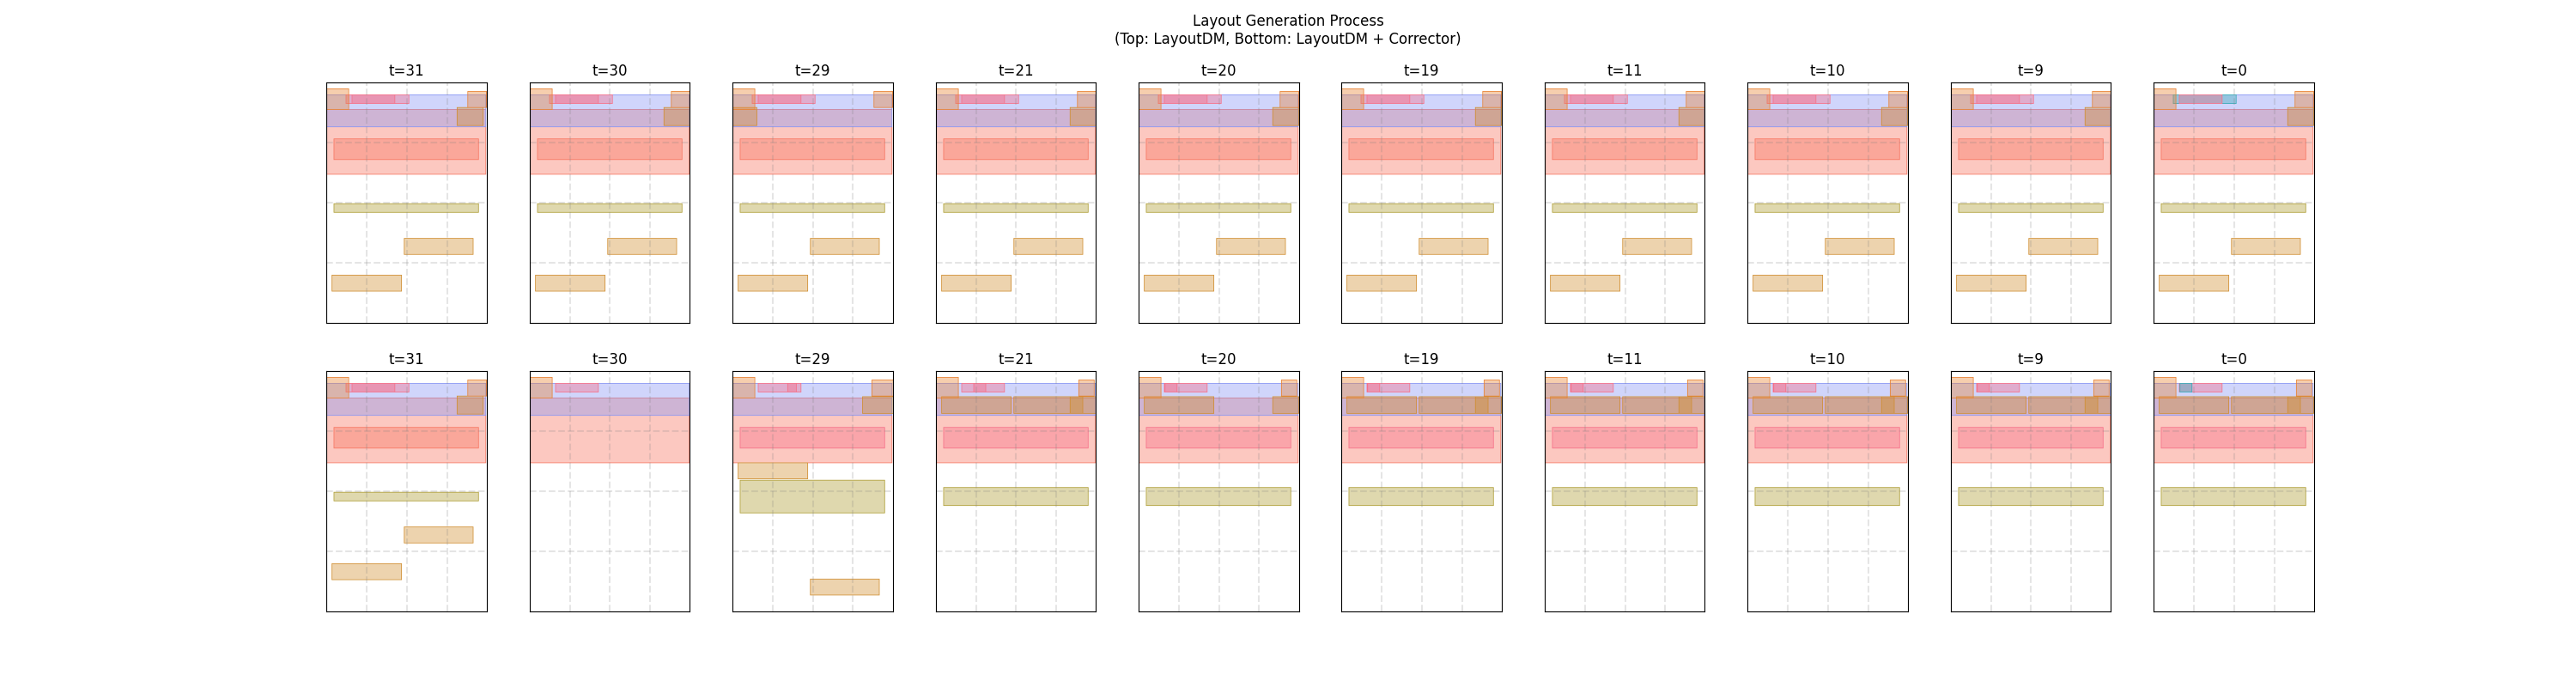

In [7]:
from PIL import Image

result = Image.open(OUTPUT_DIR / "sample0.png")
result